# EPPES examples

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import eppes
import scipy
from scipy.stats import multivariate_normal as mvnor
from scipy.linalg import inv, norm, cholesky
from numpy import zeros, ones, eye, arange, mean

Linear example

In [2]:
npar = 3
trueSigma = eye(npar) * 0.8
truemu = arange(1,npar+1)
R = cholesky(trueSigma)
sigeps = 0.8 # Error std in observations.

Initial EPPES parameters mu, W, Sig, n.

In [3]:
mu = ones(npar)*0.0
W  = eye(npar)*10**2
Sig = eye(npar)*1.0**2  # this has to be big enough
n = 1  # how well we know Sig

In [4]:
nens  = 51 # ensemble size
nobs  = 20 # n:o of observations in one stage
nsimu = 100 # number of simulation stages

muall = zeros((nsimu,npar))
signorm = zeros((nsimu,1))
Wnorm = zeros((nsimu,1))

eppesdata = eppes.EppesData()
eppesdata.add(mu=mu,Sig=Sig,W=W,n=n)

for isimu in range(nsimu):
    # sample one theta from the true dist
    theta =  mvnor.rvs(size=1,mean=truemu,cov=trueSigma)
    
    # we directly observe theta with error sigeps
    thetaobs = mvnor.rvs(size=nobs,mean=theta,cov=np.eye(npar)*sigeps**2)
    
    # posterior for theta when prior is prior N(mu,Sigma)
    Sigpost = inv(eye(npar)/sigeps**2*nobs+inv(Sig))
    mupost = Sigpost.dot(mean(thetaobs,axis=0)/sigeps**2*nobs+inv(Sig).dot(mu))
    
    # ensemble is drawn directly from the posterior
    thetaens = mvnor.rvs(size=nens,mean=mupost,cov=Sigpost)
    
    # update hyper parameters according to the ensemble
    [mu,W,Sig,n] = eppes.eppesupdate(thetaens,mu,W,Sig,n)
    eppesdata.add(mu=mu,Sig=Sig,W=W,n=n)

    # save
    # muall[isimu,:] = mu 
    signorm[isimu] = norm(Sig-trueSigma)
    Wnorm[isimu]   = norm(W)

muall = eppesdata['mu']
eppesdata.names = ['mu1','mu2','mu3']

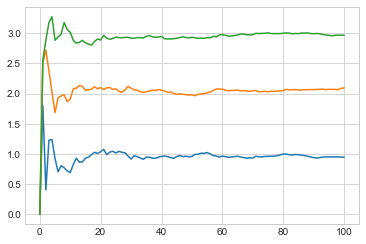

In [5]:
eppesdata.plot()

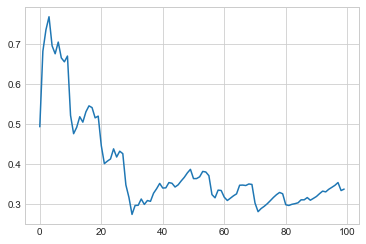

In [6]:
plot(np.arange(nsimu),signorm);

In [7]:
# draw confidence ellipse
def ellipse(mu,cmat,plotit=False):
    t = np.linspace(0,2*np.pi)
    R = cholesky(cmat)
    x = mu[0] + R[0,0]*np.cos(t)
    y = mu[1] + R[0,1]*np.cos(t) + R[1,1]*np.sin(t)
    if plotit:
        plot(x,y)
        return
    return x,y

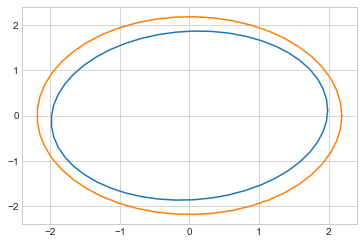

In [8]:
# compare true contour to estimated
x,y = ellipse([0,0],Sig[0:2,0:2]*6)
x2,y2 = ellipse([0,0],trueSigma[0:2,0:2]*6)

plot(x,y);
plot(x2,y2);

# Lorenz95 example

In [9]:
import numba

@numba.jit(nopython = True, parallel=False) 
def lorenz95_ode(t, y, K=40, J=0, F=8.0, gupars=np.array([0.0, 0.0])):

    if y.size !=  K+J*K:
        raise ValueError('size error in Lorenz95 ode system')
    ydot = np.empty_like(y)

    if J>0: # full model
        # other parameters are fixed here
        c = 10.0; b = 10.0; h = 0.1; Fy = 8.0

        xs = y[0:K]
        xf = y[K:]
        dxs = ydot[0:K]
        dxf = ydot[K:]

        #  the slow part
        for i in numba.prange(K):
            dxs[i] = -xs[i-2]*xs[i-1] + xs[i-1]*xs[(i+1)%K] - xs[i] + F - h*c/b*xf[(i-1)*J:i*J].sum()
        #  the fast part
        for j in numba.prange(K*J):
            dxf[j] = -c*b*xf[(j+1)%(K*J)]*(xf[(j+2)%(K*J)] - xf[j-1]) - c*xf[j] + c/b*Fy + h*c/b*xs[j%J]

    else: # the parameterized simpler model
        gu = gupars[0]+ gupars[1]*y
        for i in numba.prange(K):
            ydot[i] = -y[i-2]*y[i-1] + y[i-1]*y[(i+1)%K] - y[i] + F - gu[i]

    return ydot

def l95(t, y0, K=40, J=0, F=8.0, gupars=np.array([0.0, 0.0])):
    sol = scipy.integrate.solve_ivp(fun = lambda t,y: lorenz95_ode(t,y,K=K,J=J,F=F,gupars=gupars),
                                    t_span = [t[0], t[-1]], 
                                    t_eval = t,
                                    y0 = y0).y.T
    return sol

In [10]:
# generate truth
aint = 0.4
dt = 0.0025
time = np.arange(0,120+dt,step=dt)
J=8; K=40; F = 10.0
# itial values from a short run
s0 = np.random.rand(K + J*K)
s0 = l95(np.linspace(0,1),s0,K=K,J=J,F=F)[-1]

truth = l95(time,s0,K=K,J=J,F=F)[np.arange(time.shape[0],step=int(aint/dt)),:]
truth.shape

(301, 360)

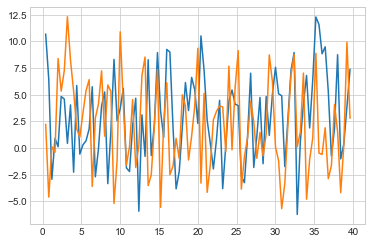

In [11]:
time0 = time[np.arange(time.shape[0],step=int(aint/dt))]
plot(time0[1:100],truth[1:100,1:3]);

In [12]:
# Forecast model settings.
sigma_a  = 0.05
sigma_ip = 0.1

F       = 10.0
gupars  = np.array([2.0, 1.0]) # initial parameter values
fc_range       = 3 # how long ahead do we forecast

nens = 30  # ensemble size
npar = gupars.size # number of parameters

##
# Initial values for hyperprior parameters.
mu  = gupars.copy() # initial prior mean
tau = 100*np.eye(2)  # accuracy of mu
sig = 0.1*np.eye(2) # initial prior covariance
n0  = 1                  # accuracy of sig
nmax = 20                # maximum n0

##
## Define number of EPPES iterations
# niter      = truth.shape[0]-fc_range-1
niter      = 50 # use a smaller number of iterations for faster illustration

def ens_ss_l95(smod,truth):
    """ENS_SS_L95 sum of squares function for EPPES L95 example"""
    ntimes,K,nens   = smod.shape
    ss     = np.zeros(nens)
    dif    = (smod-truth[:,:,np.newaxis])**2  # squared differences from data

    for t in range(ntimes):
        sigL = np.max(dif[t,:,:],axis=1)  # error std taken to be the maximum difference
        for i in range(nens):
            ss[i] += np.sum(dif[t,:,i]/sigL)
    return ss

In [13]:
eppesdata = eppes.EppesData()

for iiter in range(niter):

    time = np.arange(iiter*aint,(iiter+fc_range+1)*aint,dt)

    a = truth[iiter,0:K].copy()
    a = a + sigma_a*randn(a.size)  # analysis = truth + noise
    
    # pars_prop = mvnorr(nens,mu,sig) #  % proposed parameters from N(mu,sig)
    pars_prop = mvnor.rvs(size=nens,mean=mu,cov=sig)
    
    # launch the ensemble
    sens = np.empty((time.size,K,nens))
    for j in range(nens):
        s0 = a + sigma_ip*randn(a.size)       # initial value        
        gupars = pars_prop[j,:]         # forecast model parameters
        sens[:,:,j] = l95(time,s0,gupars=gupars,F=F)  # run the forecast model

    # sum of squares for ensemble members is calculated in function ens_ss_l95.m
    smod = sens[int(aint/dt)-1::int(aint/dt),:,:] #   % model response at data points
    sobs = truth[iiter:iiter+fc_range+1,0:40]
    ss = ens_ss_l95(smod,sobs)
    pars_new = eppes.logresample(pars_prop,ss)[0]
  
    # update the parameters
    mu,tau,sig,nn = eppes.eppesupdate(pars_new,mu,tau,sig,n0)
    n0 = np.min([nn,nmax]) # parameter n0 is at most nmax
    eppesdata.add(mu=mu,Sig=sig,W=tau,n=n0)

In [14]:
truth.shape, smod.shape, sobs.shape,  pars_new.shape, sens.shape

((301, 360), (4, 40, 30), (4, 40), (30, 2), (641, 40, 30))

In [15]:
eppesdata.names = ['mu1','mu2']
eppesdata['mu']

array([[2.33673, 1.10412],
       [2.60571, 1.04599],
       [2.77048, 1.0836 ],
       [2.86756, 1.03835],
       [2.90806, 1.01224],
       [2.98021, 0.9555 ],
       [2.98816, 0.96011],
       [3.00943, 0.94313],
       [3.00726, 0.94375],
       [3.01761, 0.94095],
       [3.04064, 0.93834],
       [3.07247, 0.93793],
       [3.09241, 0.9282 ],
       [3.10667, 0.92183],
       [3.11005, 0.919  ],
       [3.12253, 0.9146 ],
       [3.12193, 0.9106 ],
       [3.14153, 0.90155],
       [3.15584, 0.89677],
       [3.16027, 0.89045],
       [3.17404, 0.88999],
       [3.18721, 0.88603],
       [3.20509, 0.88304],
       [3.22273, 0.87976],
       [3.2374 , 0.87441],
       [3.23967, 0.87352],
       [3.25566, 0.87098],
       [3.27332, 0.86851],
       [3.28649, 0.86635],
       [3.29318, 0.86282],
       [3.29595, 0.86064],
       [3.30002, 0.8617 ],
       [3.30525, 0.85999],
       [3.31603, 0.85966],
       [3.32647, 0.85533],
       [3.33045, 0.85455],
       [3.33734, 0.85125],
 

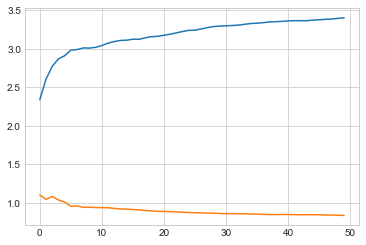

In [16]:
eppesdata.plot()